In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,125 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,375 kB]
Fetched 3,733 kB in 4s (966 kB/s)
Reading package lists... Done

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.4.3/spark-3.4.3-bin-hadoop3.tgz

In [ ]:
!tar xf /content/spark-3.4.3-bin-hadoop3.tgz

In [ ]:
!pip install -q findspark

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=0b5b5ea976b52a9fb6288b3bc6898c3adf2d1a5c528e9a401a85b550e9d1a0a0
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
!pip install py4j

In [ ]:
import os
import sys

import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T




In [ ]:
spark = SparkSession \
        .builder \
        .appName("PySpark Shell") \
        .getOrCreate()

spark

Data Preparation

In [ ]:


# Loading the US_YouTube_Trending_Final_Merged_Processed1.csv file into a DataFrame
df = spark.read.option("header", True).csv("/content/drive/MyDrive/WQD 7007 Group Project Dataset/US_YouTube_Trending_Final_Merged_Processed1.csv")

# Print the DataFrame schema
df.printSchema()

# Show the first few rows of the DataFrame
df.show(5)


root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- categoryId: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- view_count: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- dislikes: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- comments_disabled: string (nullable = true)
 |-- ratings_disabled: string (nullable = true)
 |-- id: string (nullable = true)
 |-- category: string (nullable = true)

+-----------+--------------------+--------------------+--------------------+------------+----------+--------------------+--------------------+----------+------+--------+-------------+-----------------+----------------+---+----------------+
|   video_id|               title|         publishedAt|           channelId|channelTitle|ca

In [ ]:
import re
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
import nltk

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Text Processing

In [ ]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
import pandas as pd

# Define the text preprocessing function
def preprocess_text(text):
    if text:
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        words = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        return ' '.join(words)
    return ''

# Register the function as a pandas UDF
@pandas_udf(StringType(), PandasUDFType.SCALAR)
def preprocess_text_udf(text: pd.Series) -> pd.Series:
    return text.apply(preprocess_text)

# Apply the UDF to the title and tags columns
df = df.withColumn("title_clean", preprocess_text_udf(col("title")))
df = df.withColumn("tags_clean", preprocess_text_udf(col("tags")))

# Show the result to verify
df.select("title", "title_clean", "tags", "tags_clean").show(5)


+--------------------+--------------------+--------------------+--------------------+
|               title|         title_clean|                tags|          tags_clean|
+--------------------+--------------------+--------------------+--------------------+
|DanPlan Animated ...|danplan animated ...|dan plan|by the w...|dan planby waydan...|
|TRYING ON OUTFITS...|trying outfits louie|iMovie|Louieslife...|imovielouieslifel...|
|Immortal Machine ...|immortal machine ...|animated short|an...|animated shortani...|
|Oh No Among Us So...|oh among us song ...|among us|among us...|among usamong us ...|
|my experience GRO...|experience growin...|              [None]|                none|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



Keyword Detection

In [ ]:
# Define the keyword detection function
def detect_keywords(text):
    inappropriate_keywords = ['inappropriate', 'offensive', 'banned', 'violence', 'drugs']
    words = text.split()
    return 'True' if any(word in inappropriate_keywords for word in words) else 'False'

# Register the function as a pandas UDF
@pandas_udf(StringType(), PandasUDFType.SCALAR)
def detect_keywords_udf(text: pd.Series) -> pd.Series:
    return text.apply(lambda x: detect_keywords(x))

# Apply the UDF to the cleaned title and tags columns
df = df.withColumn("title_flag", detect_keywords_udf(col("title_clean")))
df = df.withColumn("tags_flag", detect_keywords_udf(col("tags_clean")))

# Show the result to verify
df.select("title_clean", "title_flag", "tags_clean", "tags_flag").show(5)


+--------------------+----------+--------------------+---------+
|         title_clean|title_flag|          tags_clean|tags_flag|
+--------------------+----------+--------------------+---------+
|danplan animated ...|     False|dan planby waydan...|    False|
|trying outfits louie|     False|imovielouieslifel...|    False|
|immortal machine ...|     False|animated shortani...|    False|
|oh among us song ...|     False|among usamong us ...|    False|
|experience growin...|     False|                none|    False|
+--------------------+----------+--------------------+---------+
only showing top 5 rows



Sentiment Analysis

In [ ]:
# Define the sentiment analysis function
def analyze_sentiment(text):
    if text:
        blob = TextBlob(text)
        return str(blob.sentiment.polarity)
    return '0.0'

# Register the function as a pandas UDF
@pandas_udf(StringType(), PandasUDFType.SCALAR)
def analyze_sentiment_udf(text: pd.Series) -> pd.Series:
    return text.apply(lambda x: analyze_sentiment(x))

# Apply the UDF to the cleaned title and tags columns
df = df.withColumn("title_sentiment", analyze_sentiment_udf(col("title_clean")))
df = df.withColumn("tags_sentiment", analyze_sentiment_udf(col("tags_clean")))

# Show the result to verify
df.select("title_clean", "title_sentiment", "tags_clean", "tags_sentiment").show(5)


+--------------------+---------------+--------------------+--------------+
|         title_clean|title_sentiment|          tags_clean|tags_sentiment|
+--------------------+---------------+--------------------+--------------+
|danplan animated ...|            0.0|dan planby waydan...|           0.0|
|trying outfits louie|            0.0|imovielouieslifel...|           0.0|
|immortal machine ...|            0.0|animated shortani...|           0.0|
|oh among us song ...|            0.0|among usamong us ...|           0.0|
|experience growin...|            0.0|                none|           0.0|
+--------------------+---------------+--------------------+--------------+
only showing top 5 rows



Combine Results of Moderation

In [ ]:
# Define the content moderation function
def moderate_content(title_flag, tags_flag, title_sentiment, tags_sentiment):
    if title_flag == 'True' or tags_flag == 'True':
        return 'Flagged for keywords'
    elif float(title_sentiment) < -0.5 or float(tags_sentiment) < -0.5:
        return 'Flagged for negative sentiment'
    else:
        return 'Safe'

# Register the function as a pandas UDF
@pandas_udf(StringType(), PandasUDFType.SCALAR)
def moderate_content_udf(title_flag, tags_flag, title_sentiment, tags_sentiment) -> pd.Series:
    return pd.Series([moderate_content(tf, tg, ts, tg) for tf, tg, ts, tg in zip(title_flag, tags_flag, title_sentiment, tags_sentiment)])

# Apply the UDF to create a moderation result column
df = df.withColumn("moderation_result", moderate_content_udf(col("title_flag"), col("tags_flag"), col("title_sentiment"), col("tags_sentiment")))

# Show the final result
#df.select("video_id", "title", "tags", "title_flag", "tags_flag", "title_sentiment", "tags_sentiment", "moderation_result").show(5)
output_csv_path = "/content/drive/MyDrive/WQD 7007 Group Project Dataset/moderation.csv"
df.select("video_id", "title", "tags", "title_flag", "tags_flag", "title_sentiment", "tags_sentiment", "moderation_result").toPandas().to_csv(output_csv_path, index=False)


Visualization

In [ ]:


# Loading the US_YouTube_Trending_Final_Merged_Processed1.csv file into a DataFrame
df1 = spark.read.option("header", True).csv("/content/drive/MyDrive/WQD 7007 Group Project Dataset/moderation.csv")

# Print the DataFrame schema
df.printSchema()

# Show the first few rows of the DataFrame
df.show(5)


root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- categoryId: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- view_count: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- dislikes: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- comments_disabled: string (nullable = true)
 |-- ratings_disabled: string (nullable = true)
 |-- id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- title_clean: string (nullable = true)
 |-- tags_clean: string (nullable = true)
 |-- title_flag: string (nullable = true)
 |-- tags_flag: string (nullable = true)
 |-- title_sentiment: string (nullable = true)
 |-- tags_sentiment: string (nullable = true)
 |-- moderation_result: string (nullable = true)

+-----------+--------

Bar Chart


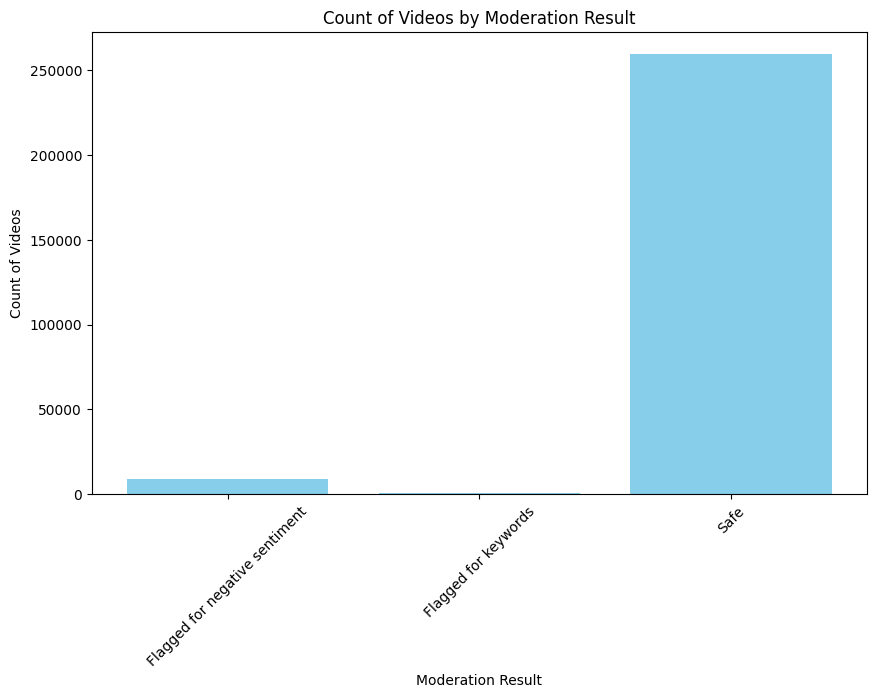

In [ ]:
import matplotlib.pyplot as plt

# Aggregate the count of videos by moderation result
moderation_counts = df1.groupBy('moderation_result').count().toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(moderation_counts['moderation_result'], moderation_counts['count'], color='skyblue')
plt.title('Count of Videos by Moderation Result')
plt.xlabel('Moderation Result')
plt.ylabel('Count of Videos')
plt.xticks(rotation=45)
plt.show()

Scatter Plot

moderation_result
Safe                              259585
Flagged for negative sentiment      8791
Flagged for keywords                 328
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


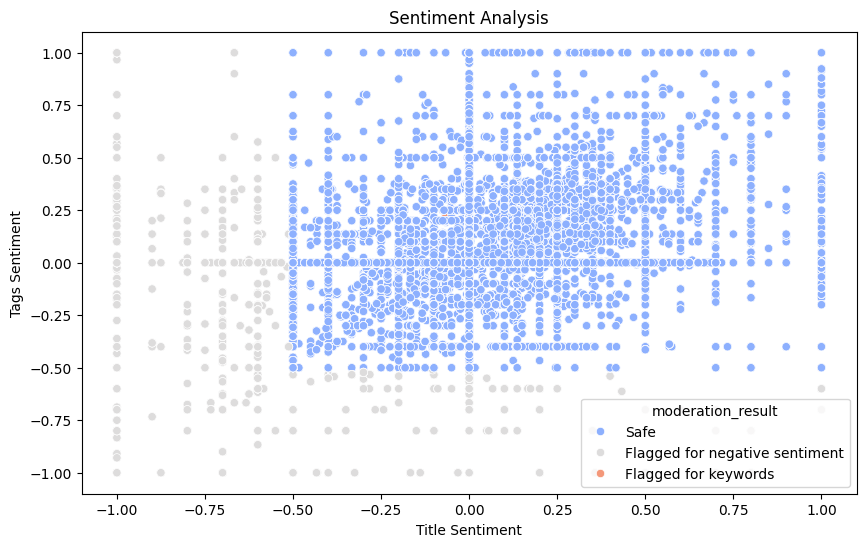

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("YouTubeModeration").getOrCreate()

# Load the data
df = spark.read.option("header", True).csv("/content/drive/MyDrive/WQD 7007 Group Project Dataset/moderation.csv")

# Convert sentiment columns to numeric (float)
df = df.withColumn("title_sentiment", col("title_sentiment").cast("float"))
df = df.withColumn("tags_sentiment", col("tags_sentiment").cast("float"))

# Convert to Pandas DataFrame
df_pandas = df.select("video_id", "title", "tags", "title_flag", "tags_flag", "title_sentiment", "tags_sentiment", "moderation_result").toPandas()

# Ensure that the moderation_result column contains valid categories
print(df_pandas['moderation_result'].value_counts())

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pandas, x='title_sentiment', y='tags_sentiment', hue='moderation_result', palette='coolwarm')
plt.title('Sentiment Analysis')
plt.xlabel('Title Sentiment')
plt.ylabel('Tags Sentiment')
plt.show()


Distribution of Sentiment Score

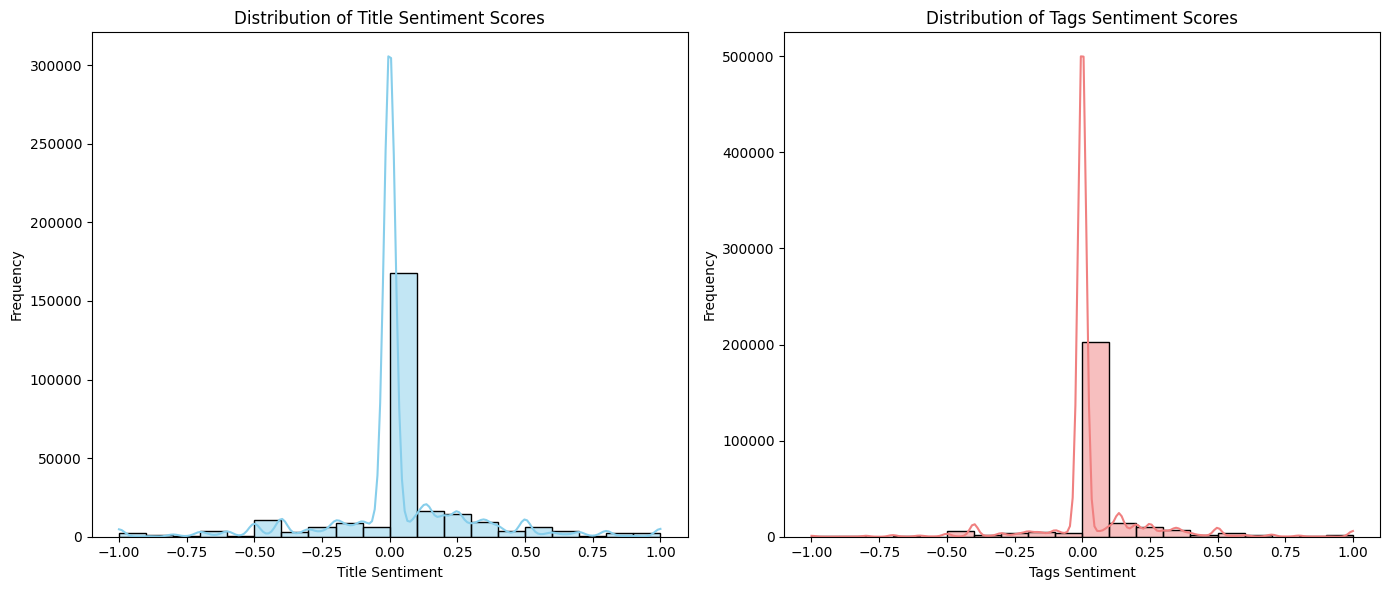

In [ ]:
# Plot histograms of sentiment scores
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_pandas['title_sentiment'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Title Sentiment Scores')
plt.xlabel('Title Sentiment')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_pandas['tags_sentiment'], bins=20, kde=True, color='lightcoral')
plt.title('Distribution of Tags Sentiment Scores')
plt.xlabel('Tags Sentiment')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Heatmap for Sentiment Co-relation

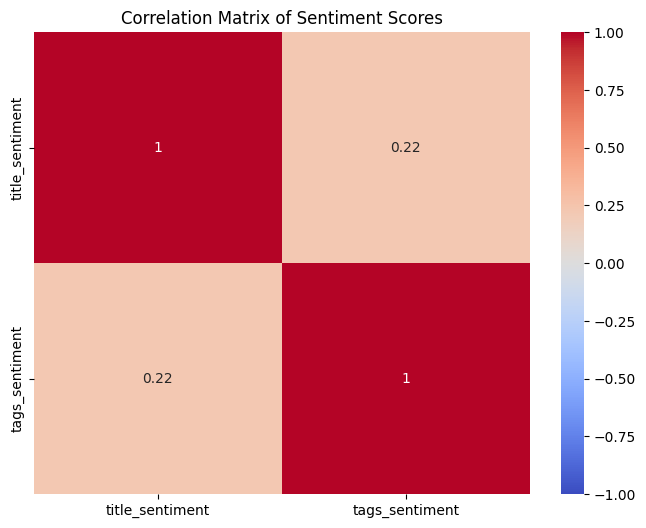

In [ ]:
# Calculate correlation matrix
corr = df_pandas[['title_sentiment', 'tags_sentiment']].corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Sentiment Scores')
plt.show()
